# Principles of Data Science

### Lecture 12: Binned ML and least-squares

_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

## Binned ML and least-squares

- Today's lecture covers 

    - Binned ML fits
    - Least squares fits
    - Binned chi-squared fits and relationship to ML
    - Wilks' theorem
    - Drawing contours, conversion between $p$-values and $Z$-scores

- Learning objectives:

    - Understand and be able to compare and constrast the various different approaches to estimation we have discussed
    - Know how to extract uncertainties on estimates from ML and least-squares fits
    - Realise the relationship between binned ML fits and least-squares fits
    - Understand the importantance and relevance of Wilks' theorem

## Recap

- Definition of the likelihood

$$ L(\theta) = \prod_{i=1}^N f(X_i; \theta) \;\; \Rightarrow \;\; \ln L(\theta) = \sum_{i=1}^N \ln f(X_i; \theta) $$

- ML estimate is $\hat{\theta}$ which minimises $-\ln L(\theta)$

- Minimum variance bound tell us

$$ V(\hat{\theta}) = - \left( \left. \frac{\partial^2 \ln L}{\partial \theta^2} \right|_{\theta=\hat{\theta}} \right)^{-1} $$


## Binned maximum likelihood

- For ML estimate
    - sum p.d.f term for each event
    - every time we call the likleihood
    
- Impractical for very large datasets with large numbers of free parameters

- Instead can use *binned* fits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')

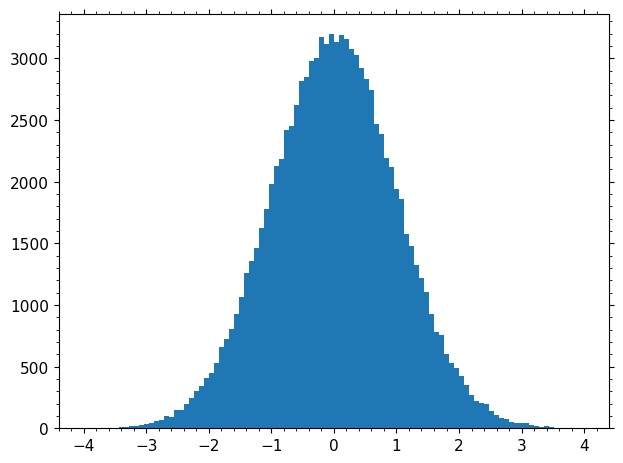

In [2]:
x = np.random.normal(size=100000)
_ = plt.hist(x, range=(-4,4), bins=100)

- Now I don't have 100K events but just 100 bins
- Each bin has an observation (an event count)
- What is the uncertainty associated to each bin?

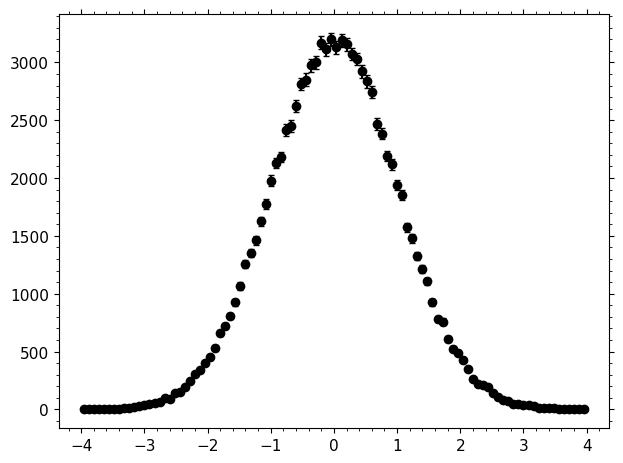

In [3]:
nh, xe = np.histogram(x, range=(-4,4), bins=100)

cx = 0.5*(xe[1:]+xe[:-1])

_ = plt.errorbar(cx, nh, nh**0.5, fmt='ko')

- relevant p.d.f is now Poisson with expectation in each bin $\nu_b$
- observed data in each bin $n_b$

$$ p(X_b) = \frac{\nu_b^{n_b} e^{-\nu_b}}{n_{b}!} $$

- so the likelihood is

$$ L = \prod_{b=1}^{N} \frac{\nu_b^{n_b} e^{-\nu_b}}{n_{b}!} $$

- the expectation in each bin, $\nu_b$, is the integral of the p.d.f over the bin

$$ \nu_b(\theta) = \int_l^h f(X; \theta) dX $$

- which we can easily evaluate from the c.d.f

$$ \nu_b(\theta) = F(X=h; \theta) - F(X=l; \theta) $$

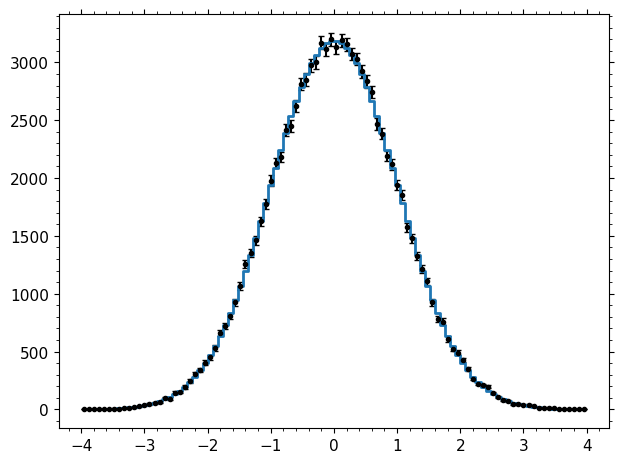

In [4]:
from scipy.stats import norm

plt.errorbar(cx, nh, nh**0.5, fmt='ko', ms=3)

N = len(x)
exp = N * np.diff( norm.cdf(xe) )
plt.step( cx, exp, lw=2, where='mid' )

- so that (using $\ln(n!) \approx n \ln n - n$)

$$ -\ln L = - \sum_{b=1}^{N} \left[ n_b \ln \nu_b - \nu_b - n_b \ln n_b + n_b\right] $$

$$ -\ln L(\theta) = - \sum_{b=1}^N \left[ n_b \ln \big( F(h_b;\theta) - F(h_l;\theta) \big) - \big( F(h_b;\theta) - F(h_l;\theta) \big)\right]  + C $$

## Binned ML fit using `iminuit`

- `iminuit` includes cost functions for binned NLLs also
- requires a function which returns the `cdf` given $X$ and the parameters $\theta$

In [5]:
from iminuit import Minuit
from iminuit.cost import BinnedNLL

def cdf(x, mu, sg):
    return norm.cdf(x, mu, sg)

nll = BinnedNLL(nh, xe, cdf)

mi = Minuit(nll, mu=0, sg=1)
mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 97.13 (chi2/ndof = 1.0)    │              Nfcn = 38               │
│ EDM = 1.13e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │  0.0029   │  0.0032   │            │            │         │         │       │
│ 1 │ sg   │  1.0009   │  0.0022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       mu       sg │
├────┼───────────────────┤
│ mu │    1e-05 1.18e-09 │
│ sg │ 1.18e-09 5.01e-06 │
└────┴───────────────────┘

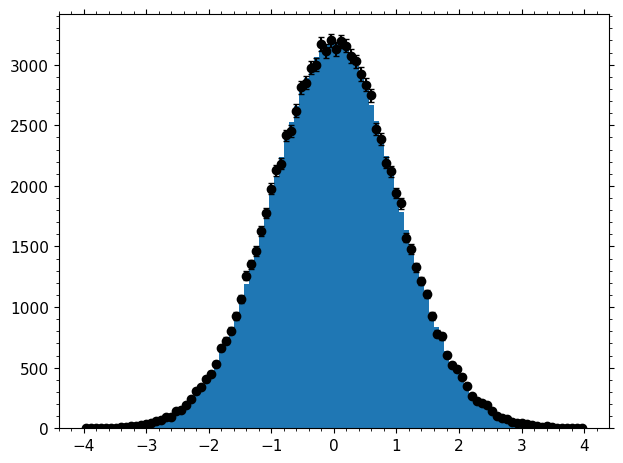

In [6]:
mi.visualize()

- We can make a comparison of the performance of unbinned *vs.* binned for a large dataset

In [7]:
from iminuit.cost import UnbinnedNLL

def pdf(x, mu, sg):
    return norm.pdf(x, mu, sg)

nll_binned = BinnedNLL(nh, xe, cdf)
nll_unbinned = UnbinnedNLL(x, pdf)

mi_binned = Minuit(nll_binned, mu=0, sg=1)
mi_unbinned = Minuit(nll_unbinned, mu=0, sg=1 ) 

- Now time the two to see what the improvement in performance is

In [8]:
from time import process_time

unbinned_start = process_time()
mi_unbinned.migrad()
mi_unbinned.hesse()
unbinned_stop = process_time()


binned_start = process_time()
mi_binned.migrad()
mi_binned.hesse()
binned_stop = process_time()

print('Unbinnned took:', unbinned_stop-unbinned_start)
print('Binned took:   ', binned_stop-binned_start)

Unbinnned took: 0.0713919999999999
Binned took:    0.0024039999999998507


## Least-squares method

- Applicable to curve fitting e.g. to fit scatter of (x,y) values
- It is a form of (non-linear) regression 
- Minimise the squared distance between the observed values $y_i$ and the prediction

 $$ y\,'_i = f(x_i; \theta) $$
    
- so that

$$ \chi^2 = \sum_{i=1}^N ( y_i - y\,'_i)^2 = \sum_{i=1}^N \big[ y_i - f(x_i; \theta) \big]^2 $$


- above assumes all $y_i$ are measured to *same* precision
    - works ok for a scatter of points
    
- often $y_i$ observations have associated errors $\sigma_i$

- incoporating the uncertainty

$$ \chi^2 = \sum_{i=1}^N \frac{ \big( y_i - f(x_i; \theta) \big)^2 }{ \sigma_i^2} $$

- this is now the squared deviation (*i.e* variance) of each observed $y_i$ from predicted $y\,'_i$

- Of course we already *know* how this is distributed
- it is the sum of squared deviations so distributed as a chi-squared
    - these are often referred to as <font color="blue">*chi-squared fits*</font>
- how many degrees of freedom are there?

 - n d.o.f is number of bins minus the number of parameters
$$ n_{\text{d.o.f}} = n_{\text{bins}} - n_{\text{pars}} $$

## Some example chi-squared fits

- `iminuit` also has a built in cost function for least squares

In [9]:
# let's define two polynomial like models

# y = mx + c
def p1(x, m, c):
    return m*x + c

# y = mx^2 + c
def p2(x, m, c):
    return m*x**2 + c

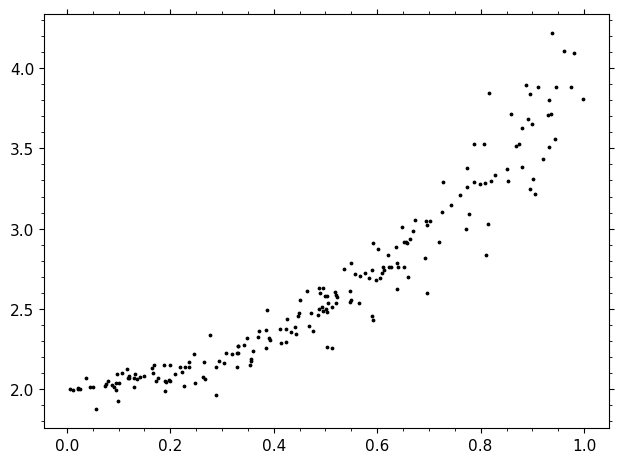

In [10]:
# generate some random x values
x_i = np.random.uniform(0, 1, size=200)

# calculate y values according to model above
y_i = p2(x_i, m=2, c=2)

# and add some noise
y_noise = 0.2*x_i**2 + 0.05 
y_i = np.random.normal(y_i, y_noise )

plt.scatter( x_i, y_i, c='k', s=3)

In [11]:
# iminuit expects errors on points
# for this example we don't have any
# so set them all to 1
y_e = np.ones_like(y_i)

# now do some fits
from iminuit.cost import LeastSquares

chisq = LeastSquares(x_i, y_i, y_e, p2)
mi = Minuit(chisq, m=2, c=2)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.398 (chi2/ndof = 0.0)    │              Nfcn = 29               │
│ EDM = 3.05e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.98    │   0.26    │            │            │         │         │       │
│ 1 │ c    │   2.02    │   0.11    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       c │
├───┼─────────────────┤
│ m │  0.0652 -0.0202 │
│ c │ -0.0202  0.0113 │
└───┴─────────────────┘

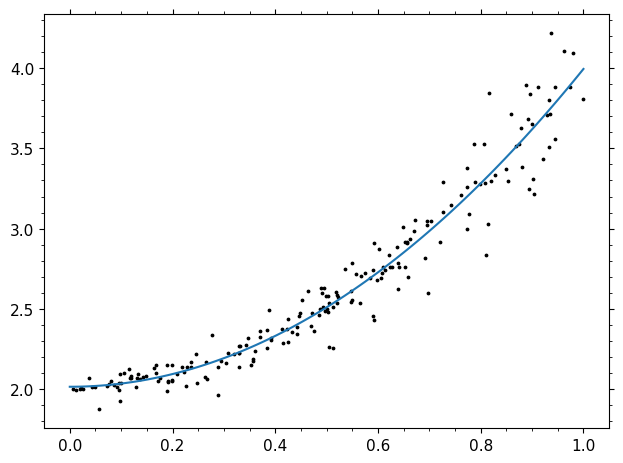

In [12]:
plt.scatter( x_i, y_i, c='k', s=3)
# plot fit result
x = np.linspace(0,1,100)
plt.plot(x, p2(x, *mi.values))

In [13]:
# can try out a straight line fit too
chisq2 = LeastSquares(x_i, y_i, y_e, p1)
mi2 = Minuit(chisq2, m=2, c=1)
mi2.migrad() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.301 (chi2/ndof = 0.0)    │              Nfcn = 32               │
│ EDM = 6.61e-24 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.95    │   0.26    │            │            │         │         │       │
│ 1 │ c    │   1.68    │   0.14    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      m      c │
├───┼───────────────┤
│ m │ 0.0678 -0.033 │
│ c │ -0.033  0.021 │
└───┴───────────────┘

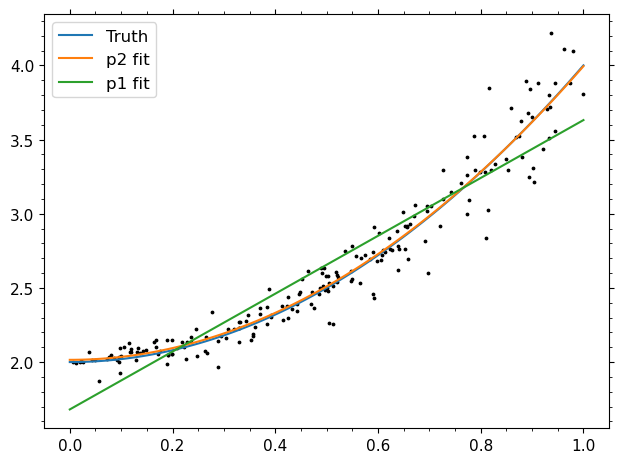

In [14]:
plt.scatter( x_i, y_i, c='k', s=3)
# plot fit result
x = np.linspace(0,1,100)
plt.plot(x, p2(x, 2, 2), label='Truth')
plt.plot(x, p2(x, *mi.values), label='p2 fit')
plt.plot(x, p1(x, *mi2.values), label='p1 fit')

plt.legend()

## Another least-squares example

- this time points with error bars

In [15]:
x_i = np.linspace(0,1,11)
y_i = p2(x_i, m=2, c=2)
y_e = 0.2*x_i**5 + 0.1

y_i = np.random.normal(y_i, y_e)

chisq = LeastSquares(x_i, y_i, y_e, p2)

mi = Minuit(chisq, m=2, c=2)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.214 (chi2/ndof = 0.7)    │              Nfcn = 29               │
│ EDM = 3e-24 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.97    │   0.16    │            │            │         │         │       │
│ 1 │ c    │   2.00    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        c │
├───┼───────────────────┤
│ m │   0.0248 -0.00498 │
│ c │ -0.00498  0.00228 │
└───┴───────────────────┘

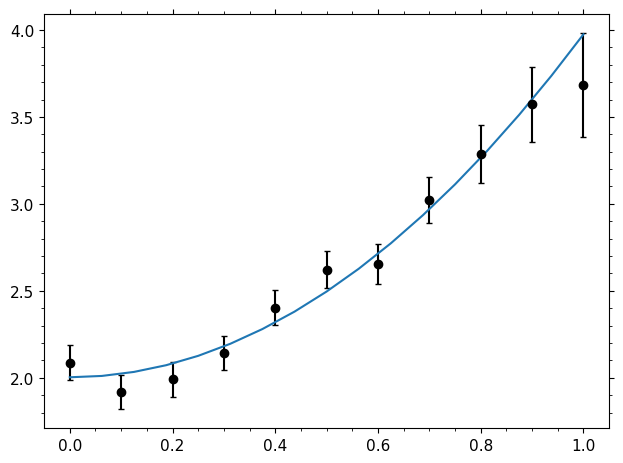

In [16]:
mi.visualize() 

# <font color="darkred">*Musical interlude...*</font>

## Binned chi-squared fit

- Nice use case of least-squares is a binned data fit
- Can bin events into a histogram
    - Observation, $y_i$, is sum of events in the bin
    - Error is $\sqrt{y_i}$
- Prediction is then the model value *at the centre-of-the bin*

- **BEWARE:** you have to remove bins with 0 events (divide by zero error)
    - We will see in a moment that for this to really work requires each bin to contain substantial (>10) events
    - If not then the Binned ML is better

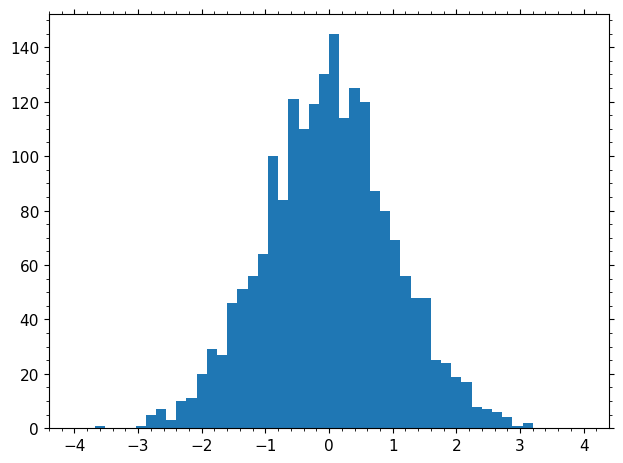

In [17]:
# generate some data
x = np.random.normal(size=2000)

# bin into a histogram
nh, xe = np.histogram( x, bins=50, range=(-4,4) )

_ = plt.hist(x, bins=50, range=(-4,  4))

In [18]:
# compute bin centres
cx = 0.5*(xe[:-1]+xe[1:])

# get model prediction at bin center
def model(x, mu, sg):
    return norm.pdf(x, mu, sg)

# I need the appproriate normalisation nevents * bin_width
bw = ( xe[-1] - xe[0] ) / ( len(xe)-1 )

# and the total number of events
N = len(x)

def pred(x, mu, sg):
    return N * bw * model(x, mu, sg)

# now we have to mask empty bins

cx = cx[ nh!=0 ]
nh = nh[ nh!=0 ]

chisq = LeastSquares( cx, nh, nh**0.5, pred)

mi = Minuit( chisq, mu=0, sg=1 ) 

mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 32.38 (chi2/ndof = 0.9)    │              Nfcn = 29               │
│ EDM = 5.36e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.002   │   0.023   │            │            │         │         │       │
│ 1 │ sg   │   1.004   │   0.017   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       mu       sg │
├────┼───────────────────┤
│ mu │ 0.000508 1.52e-05 │
│ sg │ 1.52e-05 0.000296 │
└────┴───────────────────┘

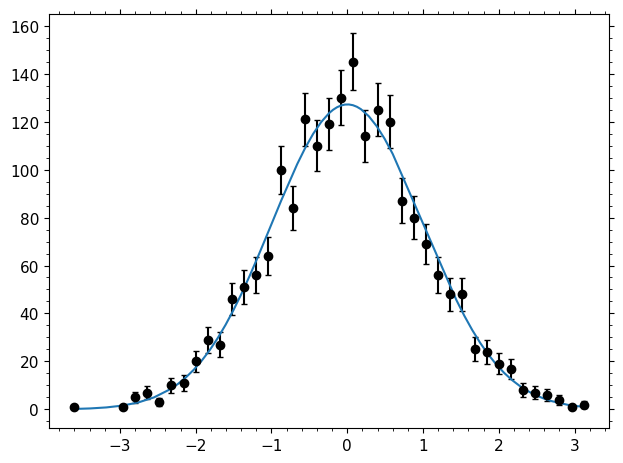

In [19]:
mi.visualize()

## Relationship to log-likelihood

- Imagine set of data events $(x_i, y_i)$ each with an uncertainty $\sigma_i$ on the $y$ value
- Assume these are Gaussian *e.g.* $y_i \pm \sigma_i$ is normally distributed
- Can you write down the likelihood for this and then the log-likelihood?

$$ L(\theta) = \prod_{i=1}^N \frac{1}{\sigma \sqrt{2\pi}} \exp \left[ - \frac{ (y_i - f(x_i;\theta))^2}{2\sigma_i^2} \right] $$ 


$$ \ln L(\theta) = \sum_{i=1}^N \ln \left( \frac{1}{\sigma \sqrt{2\pi}} \right) - \sum_{i=1}^N 
\frac{ (y_i - f(x_i;\theta))^2}{2\sigma_i^2} $$ 

$$ \ln L(\theta) = - \sum_{i=1}^N \frac{ (y_i - f(x_i;\theta))^2}{2\sigma_i^2} + C $$ 

- What we see is that

$$ \chi^2 = -2\ln L - C $$

- And therefore if we only consider the difference in $\chi^2$ or $-\ln L$ values from the minimum the constant vanishes

$$ \Delta \chi^2 = -2 \Delta \ln L $$

- This is of **huge** significance!
    - If the uncertainties are normal (which under CLT they are when $N\to \infty$) 
    - Then $-2\Delta\ln L$ is distributed as a $\chi^2$ with $n_{dof} = n_{pars}$

## Wilks' theorem

- This statement is known as **Wilks' theorem**

- As $N\to\infty$ then $-2\Delta \ln L(\theta)$ with the number of parameters in $\theta$ equal to $m$ tends to a $\chi^2$ distribution with $m$ degrees of freedom

- This is what will now allow us to draw contours on our profile likelihood plots because we know what $Z$-score and what fraction of the distribution is contained within a $\chi^2$ distribution

- **Note:** we are making an assumption when we do this that $N$ is large

- *Also note* that the difference in log-likelihood is also sometimes called the *log-likelihood ratio* (LLR)

$$ \Delta \ln L = \ln L_1 - \ln L_0 = \ln \left( \frac{L_1}{L_0} \right) $$

## Let's now do a demonstration of Wilks' theorem

- Going to quickly cook up a model with 2 parameters
- We will do a profile of $-2\Delta \ln L$ in 1D (distributed as $\chi^2$ with 1 d.o.f )
- And a profile in 2D (distributed as a $\chi^2$ with 2 d.o.f.)
- Then we will derive some intervals and contours from these
- We now realise that `iminuit` built in cost functions will already return twice the log likelihood

In [20]:
# our classic example of fitting for mu and sigma of some normally distributed data

x = np.random.normal(2, 3, size=1000)

def model(x, mu, sg):
    return norm.pdf(x, mu, sg)

n2ll = UnbinnedNLL(x, model)

mi = Minuit( n2ll, mu=2, sg=3 )
mi.migrad() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5105                       │              Nfcn = 32               │
│ EDM = 2.21e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   2.05    │   0.10    │            │            │         │         │       │
│ 1 │ sg   │   3.11    │   0.07    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────┐
│    │      mu      sg │
├────┼─────────────────┤
│ mu │ 0.00965 5.4e-06 │
│ sg │ 5.4e-06 0.00483 │
└────┴─────────────────┘

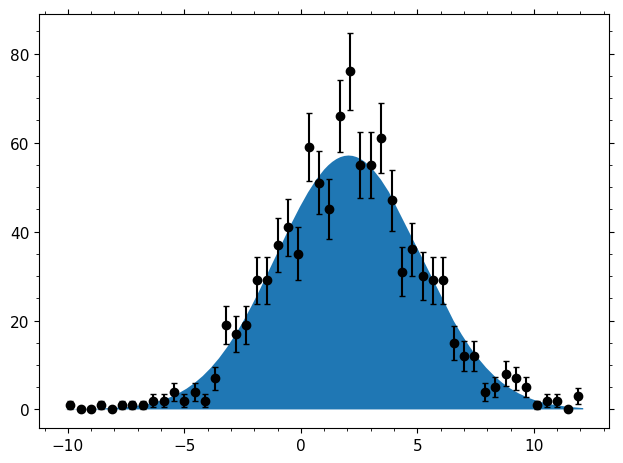

In [21]:
mi.visualize()

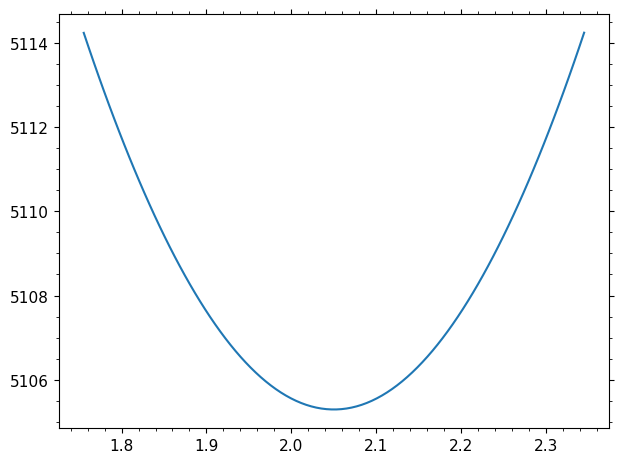

In [22]:
## profile likelihood in 1D (by hand)

mscan = np.linspace( mi.values['mu'] - 3*mi.errors['mu'], mi.values['mu'] + 3*mi.errors['mu'], 100)

n2ll_vals = []
for m in mscan:
    mi.values['mu'] = m
    mi.fixed['mu'] = True
    mi.migrad() 
    n2ll_vals.append( mi.fval )

plt.plot( mscan, n2ll_vals)

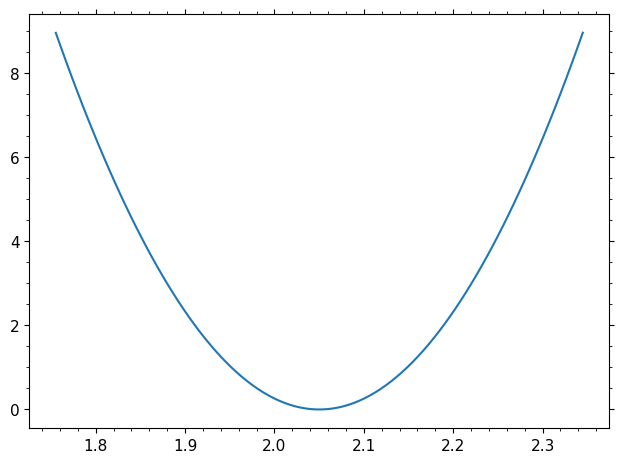

In [23]:
## before we do anything else let's reset the configuration of mi object
mi.fixed['mu'] = False

## and get the global minimum
mi.migrad()

mu_best = mi.values['mu']
sg_best = mi.values['sg']
n2ll_best = mi.fval

dn2ll = np.array(n2ll_vals) - n2ll_best

plt.plot( mscan, dn2ll )

- <font color="green">*explanantion of interval reading in lectures*</font>
- now know that the y-axis = $-2\Delta\ln L$ is distributed as a $\chi^2$ with 1 d.o.f.
- remind ourselves what that looks like and what it is

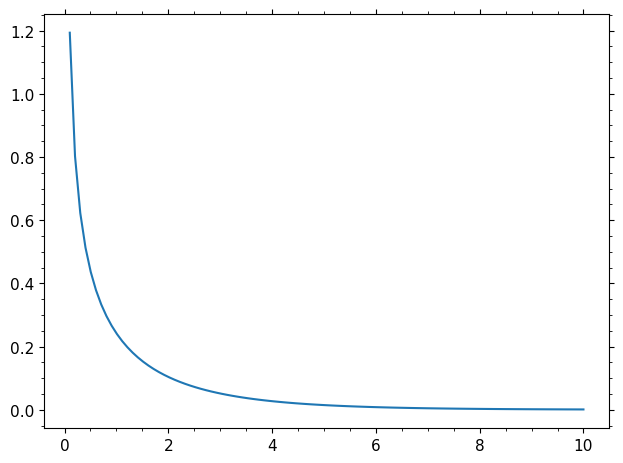

In [24]:
from scipy.stats import chi2
v = np.linspace(0,10,100)
plt.plot(v, chi2.pdf(v,1) )  

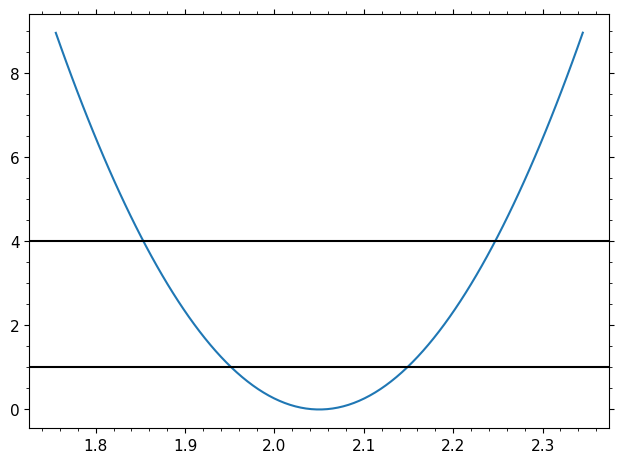

In [25]:
plt.plot( mscan, dn2ll )
plt.axhline( 1, c='k' )
plt.axhline( 4, c='k' )

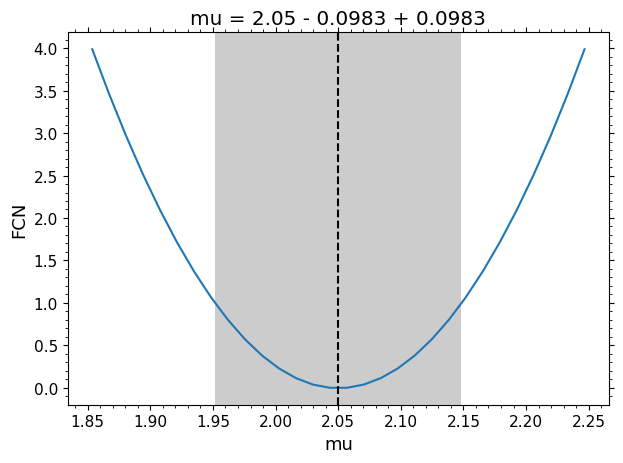

In [26]:
# can just get minuit to do all of this for us
_ = mi.draw_mnprofile('mu') 

## What about the 2D case?

- now we make a filled contour
- where $-2\Delta \ln L$ is distributed as a $\chi^2$ with 2 d.o.f

In [27]:
# reset best fit point
mi.fixed['mu'] = False
mi.fixed['sg'] = False
mi.migrad()

mscan = np.linspace( mi.values['mu'] - 4*mi.errors['mu'], mi.values['mu'] + 4*mi.errors['mu'], 100)
sscan = np.linspace( mi.values['sg'] - 4*mi.errors['sg'], mi.values['sg'] + 4*mi.errors['sg'], 100)

mscan, sscan = np.meshgrid( mscan, sscan )

n2ll_vals = []
for mp, sp in zip( mscan.flatten(), sscan.flatten() ):
    mi.values['mu'] = mp
    mi.values['sg'] = sp
    mi.fixed['mu'] = True
    mi.fixed['sg'] = True
    mi.migrad()
    n2ll_vals.append( mi.fval )
    
n2ll_vals = np.array( n2ll_vals ).reshape( mscan.shape )

n2ll_vals = n2ll_vals - n2ll_best  

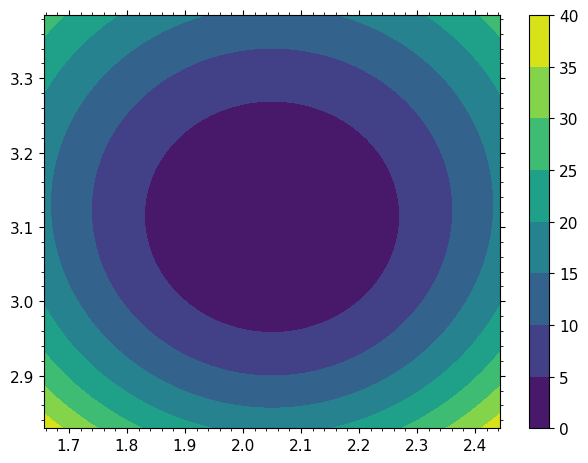

In [28]:
im = plt.contourf( mscan, sscan, n2ll_vals )
plt.colorbar(im)

- so now where do we draw the contours is it still at [1,4,9,... etc]?
- depends (answer is of some debate)
- to start with let's just do that

<a list of 3 text.Text objects>

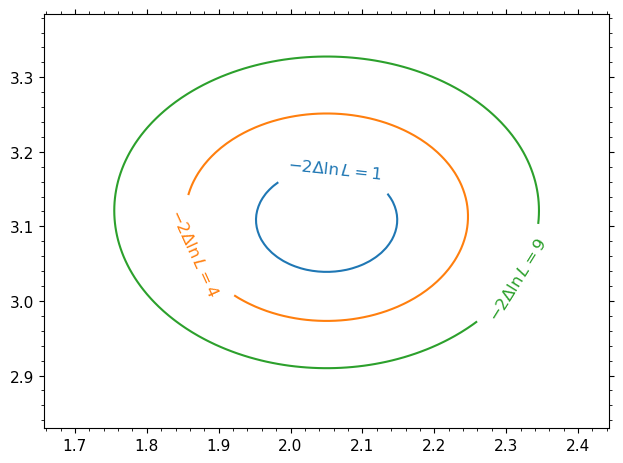

In [29]:
cl = plt.contour( mscan, sscan, n2ll_vals, levels=[1,4,9], colors=['C0','C1','C2'] )
plt.clabel( cl, cl.levels, fmt=lambda x: f'$-2\Delta\ln L={x:.0f}$' )

- but what fraction of the distribution does this contain?


- it is now a $\chi^2$ with 2 d.o.f so does not contain 68.3\%, 95.4\% etc.

In [30]:
for i in [1,2,3]:
    print( i**2, chi2.cdf(i**2, 1) , chi2.cdf(i**2, 2) )

1 0.6826894921370859 0.3934693402873665
4 0.9544997361036416 0.8646647167633873
9 0.9973002039367398 0.9888910034617577


- we see these contours now contain $39.3\%$, $86.5\%$, $98.9\%$
- so we could make our plot reflect that instead

<a list of 3 text.Text objects>

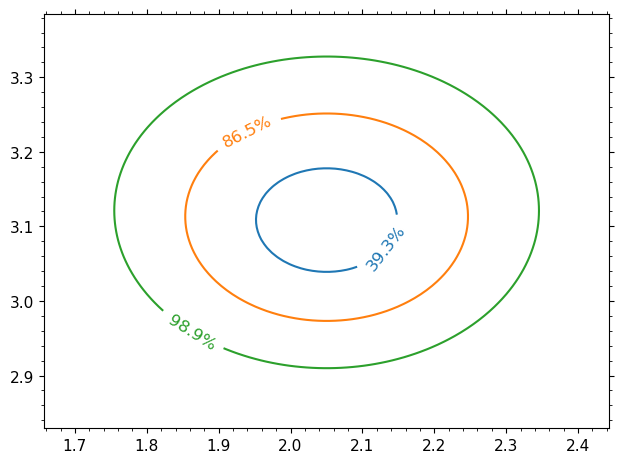

In [31]:
cl = plt.contour( mscan, sscan, n2ll_vals, levels=[1,4,9], colors=['C0','C1','C2'] )
def fmt(level):
    cl = chi2.cdf(level, 2)
    return f'{cl:4.1%}'

plt.clabel( cl, cl.levels, fmt=fmt )

- labelling by the fraction contained is sensible (avoids any confusion)
- notice that here the tips of the contours align with uncertainties

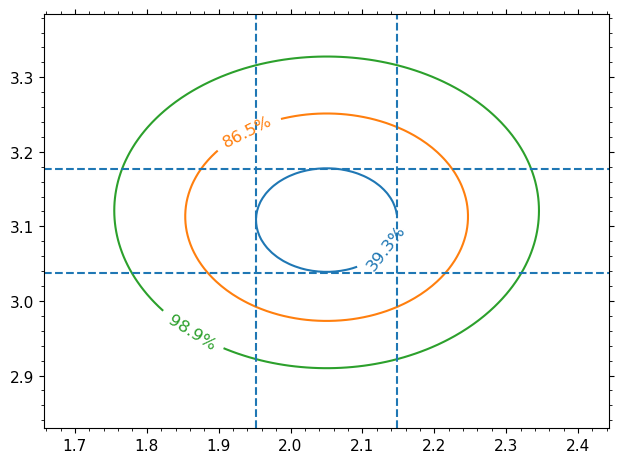

In [32]:
mi.fixed['mu'] = False
mi.fixed['sg'] = False
mi.migrad()

cl = plt.contour( mscan, sscan, n2ll_vals, levels=[1,4,9], colors=['C0','C1','C2'] )
plt.clabel( cl, cl.levels, fmt=fmt )
plt.axvline( mi.values['mu'] - mi.errors['mu'], c='C0', ls='--')
plt.axvline( mi.values['mu'] + mi.errors['mu'], c='C0', ls='--')
plt.axhline( mi.values['sg'] - mi.errors['sg'], c='C0', ls='--')
plt.axhline( mi.values['sg'] + mi.errors['sg'], c='C0', ls='--')

- you could also label these as the $1\sigma$, $2\sigma$ *etc.* contours 
    - which some people do
    
- but it can be misleading because of what others (IMO incorrectly do)
    - which is draw the 68.3%, 95.4% *etc.* contours and label those as $1\sigma$, $2\sigma$ *etc.*
    
- much better to say what fraction your contour contains

- question then is where do I draw the contour in 2D that contains 68.3%?

- I want to find the value for which `chi2.cdf(x, 2)` gives 68.3%
- so need inverse c.d.f which is the p.p.f

In [33]:
for sigma in [1,2,3]:
    n2dll_in_1d = sigma**2
    frac_in_1d  = chi2.cdf(sigma**2, 1)
    n2dll_in_2d = chi2.ppf( frac_in_1d, 2 )
    frac_in_2d  = chi2.cdf( n2dll_in_2d, 2 )
    print( sigma, n2dll_in_1d, frac_in_1d, n2dll_in_2d, frac_in_2d)

1 1 0.6826894921370859 2.295748928898636 0.6826894921370859
2 4 0.9544997361036416 6.180074306244173 0.9544997361036416
3 9 0.9973002039367398 11.829158081900795 0.9973002039367398


In [39]:
# slightly fancier way
from tabulate import tabulate
print_rows = [ [ sigma, sigma**2, chi2.cdf(sigma**2,1), 
                 chi2.ppf( chi2.cdf(sigma**2,1),2), chi2.cdf( chi2.ppf( chi2.cdf(sigma**2,1),2),2) ] 
                 for sigma in [1,2,3] ]

print( tabulate(print_rows, headers=['Z-score', '2DLL 1D','Frac 1D', '2DLL 2D', 'Frac 2D'] ) )

  Z-score    2DLL 1D    Frac 1D    2DLL 2D    Frac 2D
---------  ---------  ---------  ---------  ---------
        1          1   0.682689    2.29575   0.682689
        2          4   0.9545      6.18007   0.9545
        3          9   0.9973     11.8292    0.9973


- so should draw at $-2\Delta \ln L= 2.3$, $6.2$, $11.8$, *etc*

<a list of 3 text.Text objects>

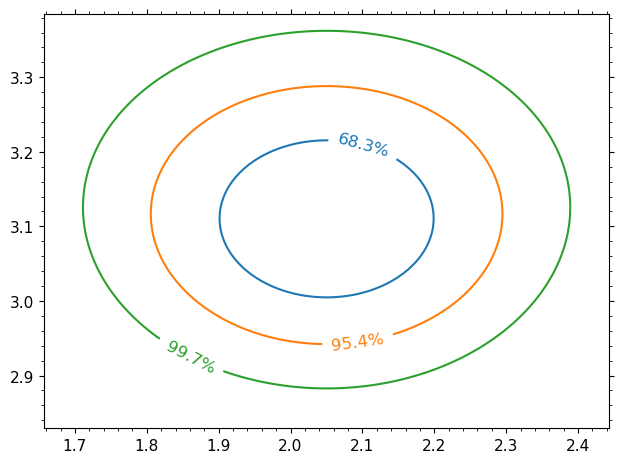

In [35]:
levels = [ chi2.ppf( chi2.cdf(i**2, 1), 2) for i in [1,2,3] ]
cl = plt.contour( mscan, sscan, n2ll_vals, levels=levels, colors=['C0','C1','C2'] )
plt.clabel( cl, cl.levels, fmt=fmt )

- my view is that it is misleading to label these as $1\sigma$, $2\sigma$ 
- but many people do (and I think conventions are mixed)
- `iminuit` does this for example
- never-the-less it is still very good at producing these plots for us anyway

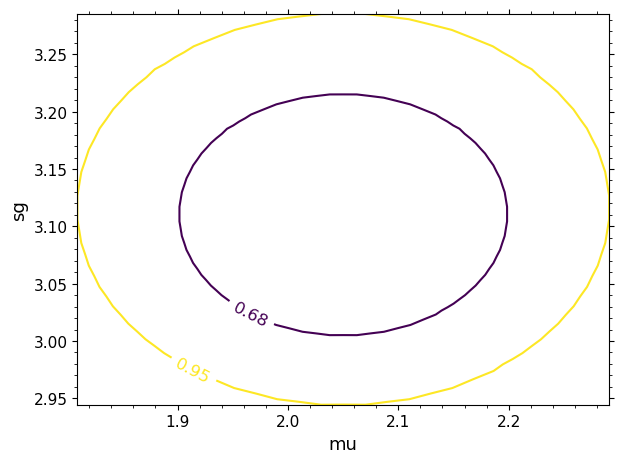

In [36]:
mi.draw_mncontour('mu','sg', cl=[0.68,0.95])

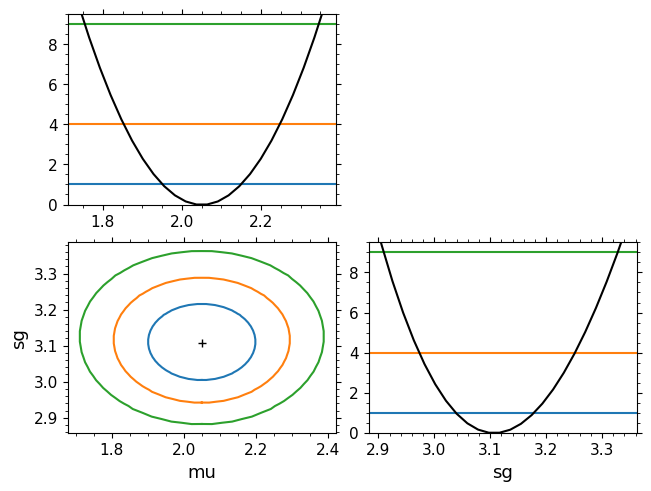

In [37]:
_ = mi.draw_mnmatrix(cl=[1,2,3])

# End of Lecture 12

By the end of this lecture you should:

  - Understand and be able to compare and constrast the various different approaches to estimation we have discussed
  - Know how to extract uncertainties on estimates from ML and least-squares fits
  - Realise the relationship between binned ML fits and least-squares fits
  - Understand the importantance and relevance of Wilks' theorem